/home/josebraz/anaconda3/envs/geo_env/lib/python3.9/site-packages/pysal/lib/cg/alpha_shapes.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/home/josebraz/anaconda3/envs/geo_env/lib/python3.9/site-packages/pysal/lib/cg/alpha_shapes.py:155: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/home/josebraz/anaconda3/envs

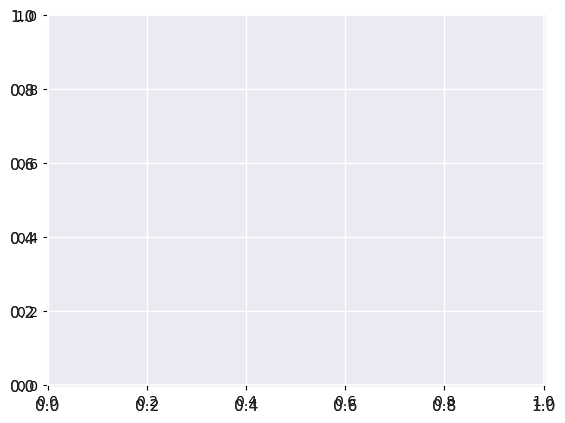

In [2]:
import numpy as np
import geopandas as gpd

from explore import *
from utils import *
from graphic import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

import contextily as cx

import warnings
warnings.filterwarnings('ignore')

# dados de https://appeears.earthdatacloud.nasa.gov

In [3]:
df = read_burn_df()
df.drop(["pais", "estado", "municipio", "bioma", "diasemchuva", "precipitacao", "riscofogo", "frp"], axis=1, inplace=True)
df = df[(df["simp_satelite"] != "ATSR") & (df["simp_satelite"] != "TRMM")]

pais_folder = os.path.join(aux_folder, "ibge/BR_Pais_2021")

wrs2: gpd.GeoDataFrame = gpd.read_file('aux/grade_tm_am_do_sul', engine="pyogrio")
pais_shape: gpd.GeoDataFrame = gpd.read_file(pais_folder, engine="pyogrio")

join = gpd.sjoin(pais_shape, wrs2)
brasil_wrs2 = wrs2.iloc[join['index_right'].unique()]

In [4]:
# parametros escolhidos para a aplicação do AQ-FA
quadrat_width = 0.005
burned_area_calc = BurnedAreaCalcPercentile()
min_area_percentage = 0.1
threshold_satellite = 2

In [19]:
import time
import glob
from multiprocessing import Pool

files = [
    ('linear_2-5_15', lambda: linear_burned_area_calc(2.5, 15)),
    ('exponential_2-5_15_2', lambda: polinomial_burned_area_calc(2.5, 15, 2)),
    ('exponential_2-5_15_3', lambda: polinomial_burned_area_calc(2.5, 15, 3)),
    ('percentile_1', lambda: BurnedAreaCalcPercentile(exponent=1))
]

def validate(args) -> dict:
    aq30m_file, quadrat_width, index = args
    aq30m_file, quadrat_width = str(aq30m_file), float(quadrat_width)
    path, row, start, end = get_infos_from_aq30m(aq30m_file)
    burned_area_calc = files[int(index)][1]()    
    region = get_landsat_geometry(path, row)
    aqm_gdf, aqm_normalized_gdf = read_file_normalized_cached(path, row, aq30m_file, quadrat_width)

    explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
    explorer = SatellitesExplore(explore_df, 
                                    delimited_region=region,
                                    quadrat_width=quadrat_width, 
                                    burned_area_calc=burned_area_calc,
                                    min_area_percentage=min_area_percentage,
                                    threshold_satellite=threshold_satellite)
    burned = explorer.get_burned_areas()

    model_area_km2 = burned['burned_are'].sum() / 1000000
    temp = gpd.GeoDataFrame({ 'value': burned['burned_fac'], 'geometry': burned['geometry'] }, crs=burned.crs)
    d = evaluate_gpd(aqm_normalized_gdf, temp)
    d['start_dt'] = start
    d['end_dt'] = end
    d['reference_area_km2'] = aqm_gdf['km2'].sum()
    d['model_area_km2'] = model_area_km2
    d['orbita_ponto'] = f"{path:03d}/{row:03d}"
    return d

for index in range(len(files)): 
    dt = pd.DataFrame({ 'aqm30_file': glob.glob("aq30m/*.zip") })
    items = [np.append(np.append(dt.iloc[i].values, quadrat_width), index) for i in range(len(dt))]
    print(items)
    with Pool(4) as pool:
        values = pool.map(validate, items, chunksize=1)
        dt = pd.concat([dt, pd.DataFrame(values)], axis=1)
        dt.to_csv(f'results/validate_results_{files[index][0]}.csv')


[array(['aq30m/LS8_AQM_222_067_20190923_0107.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_220_074_20200927_0114.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_226_071_20191005_0111.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_221_073_20200918_0113.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_220_065_20170919_0105.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_224_069_20210910_0109.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_221_073_20210921_0113.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_221_067_20210719_0107.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_220_065_20210829_0105.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_221_070_20190916_0110.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_221_067_20190916_0107.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_226_071_20170913_0111.zip', 0.005, 0], dtype=object), array(['aq30m/LS8_AQM_225_069_20180909_0109.zip', 0.005, 0], dtype=object), array(['aq3

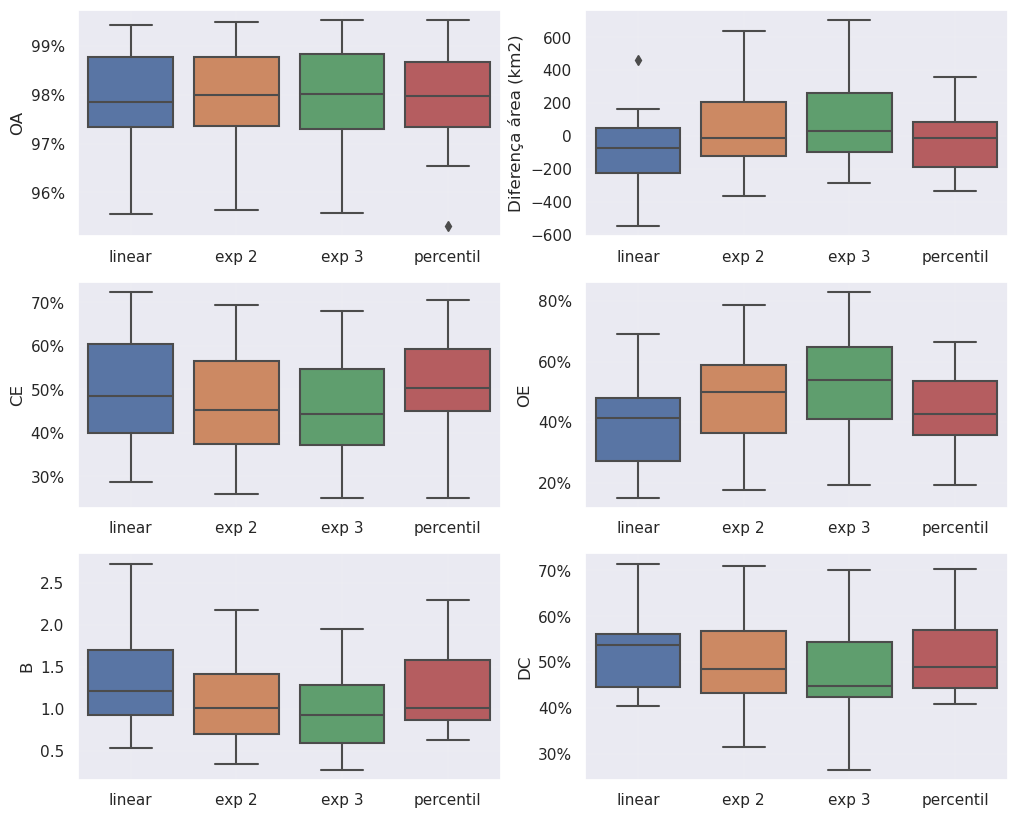

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs: list[plt.Axes] = axs.flat

files = [
    'results/validate_results_linear_2-5_15.csv',
    'results/validate_results_exponential_2-5_15_2.csv',
    'results/validate_results_exponential_2-5_15_3.csv',
    'results/validate_results_percentile_1.csv'
]

names = ['linear', 'exp 2', 'exp 3', 'percentil']

def read_set(file: str, name: str):
    data_set = pd.read_csv(file)
    data_set['eval'] = name
    data_set['Diferença área (km2)'] = data_set['reference_area_km2'] - data_set['model_area_km2']
    return data_set

data_sets = pd.concat([read_set(file, name) for (file, name) in zip(files, names)], ignore_index=True)
data_sets['OA'] = data_sets['ACC']

columns = ['OA', 'Diferença área (km2)', 'CE', 'OE', 'B', 'DC']

for i, column in enumerate(columns):
    sns.boxplot(ax=axs[i], data=data_sets, y=column, x="eval", orient='v', )
    if column in ['OA', 'CE', 'OE', 'DC']:
        axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    axs[i].set(xlabel=None)
    axs[i].yaxis.grid(True, linewidth=0.075) # Hide the horizontal gridlines
    axs[i].xaxis.grid(True, linewidth=0.075) #

fig.savefig(os.path.join(image_folder, 'comparacao_evals.pdf'), bbox_inches="tight")

In [24]:
temp = pd.read_csv("results/validate_results_percentile_1.csv")
columns = ['orbita_ponto', 'start_dt', 'end_dt', 'ACC', 'CSI', 'CE', 'OE', 'B', 'DC', 'reference_area_km2', 'model_area_km2']
print('\n'.join(to_pretty_table_latex(temp, columns, ["DC"]).values))

\multirow{2}{*}{221/070} & 25/08/2017 & 98.43\% & 30.76\% & 1.03 & $697.9Km^2$ \\
                         & 10/09/2017 & 0.54 & 28.38\% & 70.40\% & $721.8Km^2$ \\
\hline
\multirow{2}{*}{221/070} & 31/08/2019 & 97.87\% & 31.83\% & 0.97 & $882.2Km^2$ \\
                         & 16/09/2019 & 0.51 & 33.72\% & 67.20\% & $856.4Km^2$ \\
\hline
\multirow{2}{*}{224/069} & 25/08/2021 & 97.29\% & 25.08\% & 0.77 & $1181.5Km^2$ \\
                         & 10/09/2021 & 0.48 & 42.53\% & 65.03\% & $906.8Km^2$ \\
\hline
\multirow{2}{*}{225/069} & 24/08/2018 & 99.52\% & 54.26\% & 1.76 & $111.1Km^2$ \\
                         & 09/09/2018 & 0.41 & 19.44\% & 58.34\% & $195.4Km^2$ \\
\hline
\multirow{2}{*}{220/074} & 11/09/2020 & 97.19\% & 51.52\% & 1.48 & $699.0Km^2$ \\
                         & 27/09/2020 & 0.41 & 28.13\% & 57.89\% & $1034.4Km^2$ \\
\hline
\multirow{2}{*}{221/067} & 31/08/2019 & 97.35\% & 28.45\% & 0.66 & $1006.1Km^2$ \\
                         & 16/09/2019 & 0.40 & 52.93\% & 56.

In [32]:
from multiprocessing import Pool

argss = [[brasil_wrs2.loc[index]['ORBITA'], brasil_wrs2.loc[index]['PONTO'], 
          f'{start} 00:00:00-03:00', f'{end} 23:59:59-03:00', year] 
          for year in [2015, 2014, 2013, 2012, 2011, 2010]
          for index in brasil_wrs2.T
          for (start, end) in get_year_date_pairs(year)]

def calculate(args) -> float:
    path, row, start, end, year = args
    path, row = int(path), int(row)
    file_name = f'''aq_fa_{year}/AQ-FA_{path}_{row}_{start.split(' ')[0]}_{end.split(' ')[0]}'''
    if os.path.exists(file_name): return 0.0
    try:
        explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
        if len(explore_df) == 0:
            os.mkdir(file_name) # cria uma pasta vazia só pra marcar
            return 0.0
        region = get_landsat_geometry(path, row)
        explorer = SatellitesExplore(explore_df, 
                                     delimited_region=region,
                                     quadrat_width=quadrat_width, 
                                     burned_area_calc=burned_area_calc,
                                     min_area_percentage=min_area_percentage,
                                     threshold_satellite=threshold_satellite)
        burned = explorer.get_burned_areas()
        temp = burned[burned['value'] > 0]
        if len(temp) > 0:
            temp.to_file(file_name, engine="pyogrio")
        else:
            os.mkdir(file_name) # cria uma pasta vazia só pra marcar
        km2 = explorer.get_total_area_m_2() / 1000000
        del explore_df, explorer, region, burned
        return km2
    except KeyboardInterrupt as error:
        raise error
    except Exception as error:
        print(f"ERROR {path}/{row}", error)
        raise error

print("Computing", len(argss), "values...")
with Pool(4) as pool:
    pool.map(calculate, argss, chunksize=1)

Computing 27504 values...


In [47]:
import glob

def recompute_area(file):
    if len(os.listdir(file)) > 0:
        gdf: gpd.GeoDataFrame = gpd.read_file(file)
        SatellitesExplore.recalcule_burned_area_static(BurnedAreaCalcPercentile(), gdf)
        gdf.to_file(file, engine="pyogrio")
    return 0.0

year = 2021
args = [file
        for (start, end) in get_year_date_pairs(year)
        for file in glob.iglob(f'aq_fa_{year}/AQ-FA_*_*_{start}_{end}')]

with Pool(4) as pool:
    pool.map(recompute_area, args, chunksize=1)


In [12]:
import glob

year = 2019
aq1km = pd.read_csv('aq1km/area_queimada_aq1km.csv')
date_pairs = get_year_date_pairs(year)

def compare(args):
    start, end = args
    year, month = int(start.split('-')[0:2]) 
    files = glob.iglob(f'aq_fa_{year}/AQ-FA_*_*_{start}_{end}')
    gdfs_raw = (gpd.read_file(file, engine="pyogrio") for file in files if len(os.listdir(file)) > 0)
    gdfs_area = (SatellitesExplore.recalcule_burned_area_static(BurnedAreaCalcPercentile(), gdf).sum() for gdf in gdfs_raw)
    burned_aq1km = aq1km[(aq1km['Ano'] == year) & (aq1km['Mês'] == month)].iloc[0]['Total mensal']
    burned_aqfa = np.sum(gdfs_area) / 1000000
    return { 
        'Ano': year, 
        'Mês': month, 
        'AQ-FA': round(burned_aqfa), 
        'AQ1km': round(burned_aq1km)
    }

values = []
with Pool(5) as pool:
    values = pool.map(compare, date_pairs, chunksize=1)

data_df = pd.DataFrame(values)
data_df

Ano  Mês         AQ-FA  AQ1km
0   2019    1    4225794181   4406
1   2019    2    4223184750   2778
2   2019    3    9511480599   6181
3   2019    4    4294136114   3053
4   2019    5    3874074122   5094
5   2019    6    9753100202  12680
6   2019    7   16090239804  23566
7   2019    8   82697863852  72242
8   2019    9  107876183792  93631
9   2019   10   62828785771  50132
10  2019   11   43464300382  30130
11  2019   12   15183290184  12949

In [4]:
def validate_plot(file: str, quadrat_width: float = 0.005, burned_area_calc=None, 
                  path: int = None, row: int = None):
    label = ''
    if file.startswith("aq1km"):
        start, end = get_infos_from_aq1km(file)
        label = "AQ1km"
        if path is None or row is None:
            raise ValueError("AQ1km without path or row")
    elif file.startswith("aq30m"):
        path, row, start, end = get_infos_from_aq30m(file)
        label = "AQ30m"
    else:
        raise ValueError(f"File unknown {file}")

    geometry = get_landsat_geometry(path, row)
    aq_gdf, aq_norm_gdf = read_file_normalized_cached(path, row, file, quadrat_width)
    explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
    explorer = SatellitesExplore(explore_df, 
                                delimited_region=geometry,
                                quadrat_width=quadrat_width, 
                                burned_area_calc=BurnedAreaCalcPercentile(exponent=1) if burned_area_calc is None else burned_area_calc,
                                min_area_percentage=min_area_percentage,
                                threshold_satellite=threshold_satellite)
    xmin, ymin, xmax, ymax = geometry.bounds

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True, sharex=True)
    fig.tight_layout()

    aq_legend = 'km2' not in aq_gdf.columns
    plot_burned_gdf(ax1, aq_norm_gdf, legend=aq_legend, color_bar=False)
    configure_geografic_axes(ax1, xmin, xmax, ymin, ymax)
    cx.add_basemap(ax1, crs=aq_norm_gdf.crs.to_string())
    ax1.plot(*geometry.exterior.xy)
    ax1.set_title(label)
    if not aq_legend:
        ax1.legend(title = "{:.2f}Km²".format(aq_gdf['km2'].sum()), loc='lower left')

    explorer.show_satellites_quads_areas(ax=ax2, linewidth=0, cmap='Reds', with_color_bar=False)
    configure_geografic_axes(ax2, xmin, xmax, ymin, ymax)
    cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())
    ax2.plot(*geometry.exterior.xy)
    ax2.set_title('AQ-FA')

    print(explorer.burned_area_calc)
    burned = explorer.get_burned_areas()
    fig.savefig(os.path.join(image_folder, f'validacao_{label}_{path}_{row}.pdf'), bbox_inches="tight")
    temp = gpd.GeoDataFrame({ 'value': burned['burned_fac'], 'geometry': burned['geometry'] }, crs=burned.crs)
    print(evaluate_gpd(aq_norm_gdf, temp))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


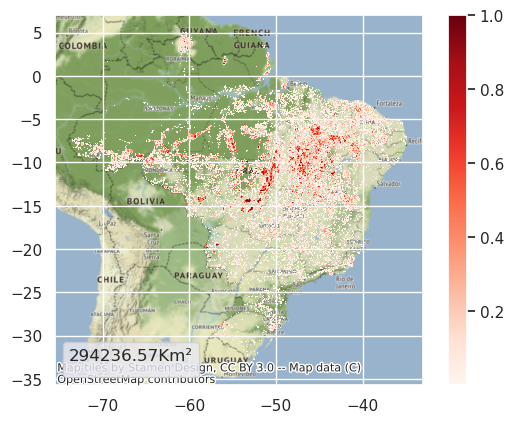

In [7]:
resolution = get_quadrat_width(distance.distance(kilometers=10))
region = pais_shape.geometry[0]
gdf_aq1km = read_geopandas('aq1km/shp/2022_*_*_aq1km_V6.zip')
gdf_aq1km = read_file_normalized(gdf_aq1km, file="aq1km_2022", region=region, quadrat_width=resolution)
gdf_aq1km: gpd.GeoDataFrame = gdf_aq1km[gdf_aq1km['value'] > 0]

ax = plt.gca()
plot_burned_gdf(ax, gdf_aq1km)
cx.add_basemap(ax, crs=gdf_aq1km.crs.to_string())

In [ ]:
aq1km_file = 'aq1km/shp/2022_*_*_aq1km_V6.zip'
aqfa_file = 'aq_fa_2022/AQ-FA*2022*'
region = pais_shape.geometry[0]

gdf_aq1km = read_geopandas(aq1km_file, region=region)
gdf_aqfa = read_geopandas(aqfa_file)
resolution = get_quadrat_width(distance.distance(kilometers=10))

print("readed...")

gdf_aq1km = read_file_normalized(gdf_aq1km, file=aq1km_file, region=region, quadrat_width=resolution)
gdf_aqfa = read_file_normalized(gdf_aqfa, file=aqfa_file, quadrat_width=resolution, column='burned_are')

print("normalized...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True, sharex=True)
fig.tight_layout()
xmin, ymin, xmax, ymax = region.bounds

plot_burned_gdf(ax1, gdf_aq1km, legend=False, color_bar=False)
configure_geografic_axes(ax1, xmin, xmax, ymin, ymax)
cx.add_basemap(ax1, crs=gdf_aq1km.crs.to_string())
ax1.set_title("AQ1km")

plot_burned_gdf(ax2, gdf_aqfa, legend=False, color_bar=False)
configure_geografic_axes(ax2, xmin, xmax, ymin, ymax)
cx.add_basemap(ax2, crs=gdf_aqfa.crs.to_string())
ax2.set_title("AQ-FA")

In [5]:
year = 2022
resolution = get_quadrat_width(distance.distance(kilometers=10))
region = pais_shape.geometry[0]

# for (start, end) in get_year_date_pairs(year):
aq1km_file = 'aq1km/shp/2022_*_*_aq1km_V6.zip'
aqfa_file = 'aq_fa_2022/AQ-FA*2022*'

gdf_aq1km = read_geopandas(aq1km_file, region=region)
gdf_aqfa = read_geopandas(aqfa_file)

    

<xarray.DataArray (y: 8394, x: 69466)>
<COO: shape=(8394, 69466), dtype=float64, nnz=1663664, fill_value=nan>
Coordinates:
  * y        (y) float64 -33.75 -33.74 -33.74 -33.73 ... 5.087 5.092 5.117 5.122
  * x        (x) float64 -73.62 -73.61 -73.61 -73.58 ... -34.81 -34.81 -34.8

In [12]:

temp = create_dataarray(gdf_aqfa, value_column='burned_fac', sparse=False)
temp

<xarray.DataArray (y: 8394, x: 69466)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 -33.75 -33.74 -33.74 -33.73 ... 5.087 5.092 5.117 5.122
  * x        (x) float64 -73.62 -73.61 -73.61 -73.58 ... -34.81 -34.81 -34.8

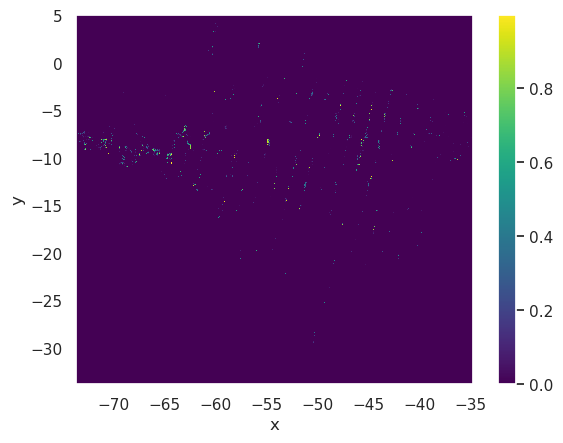

In [31]:
temp.interp(x = np.arange(temp.x[0], temp.x[-1], resolution), y = np.arange(temp.y[0], temp.y[-1], resolution)).plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


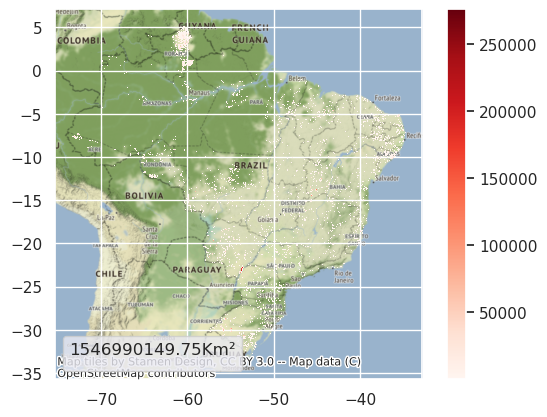

In [19]:
ax = plt.gca()
plot_burned_gdf(ax, gdf_aqfa)
cx.add_basemap(ax, crs=gdf_aqfa.crs.to_string())

aq1km/shp/2022_09_01_aq1km_V6.zip 2022-09-01 00:00:00-03:00 2022-09-30 23:59:59-03:00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HIT!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 5.225593746168151 max_range: 15
{'TP': 1112.8162219139838, 'FP': 752.13158018457, 'FN': 908.1837780882486, 'TN': 87152.86841981321, 'ACC': 0.9815368707796096, 'CE': 0.403298998147951, 'OE': 0.44937346763347125, 'B': 0.9227846620962364, 'DC': 0.5727386360220191, 'TPR': 0.5506265323665287, 'TNR': 0.9914438134328584, 'PPV': 0.5967010018520489, 'NPV': 0.9896868847757205, 'CSI': 0.4012850417429608}


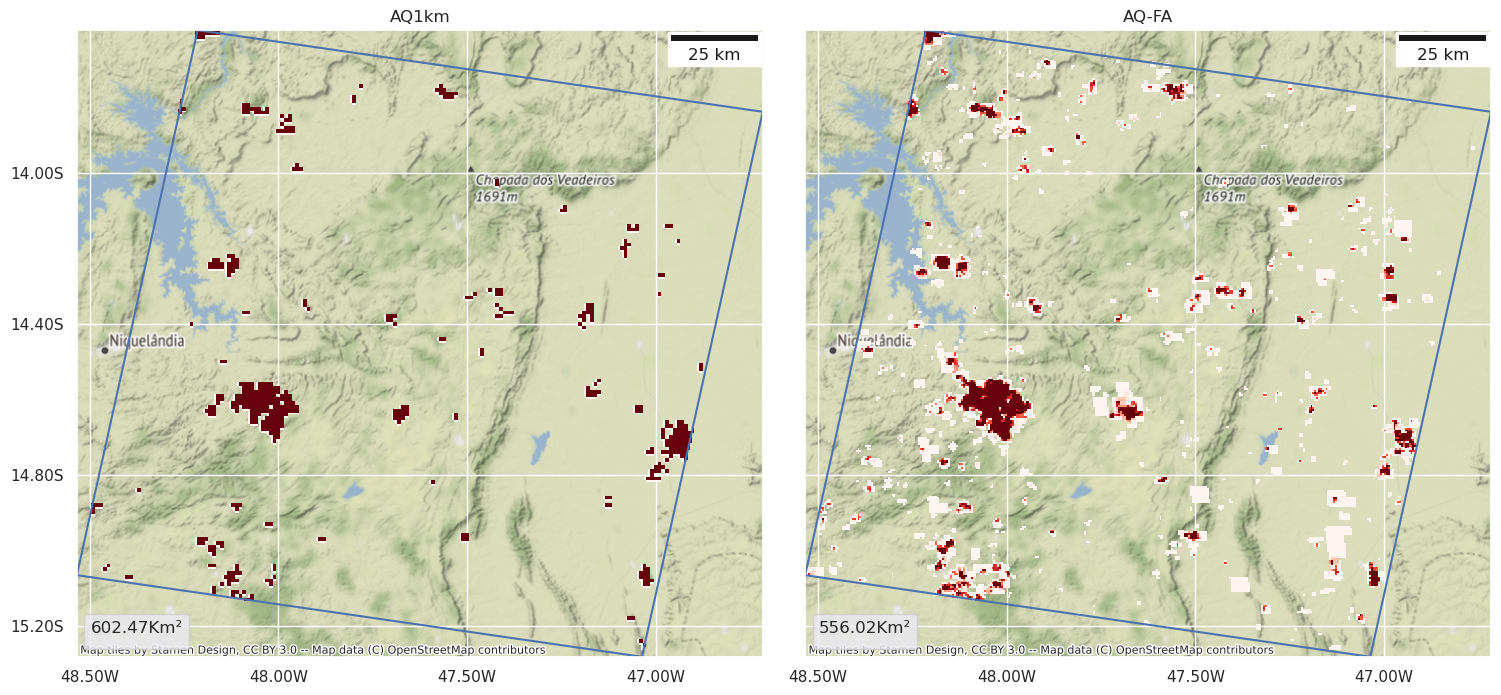

In [44]:
validate_plot(file='aq1km/shp/2022_09_01_aq1km_V6.zip', quadrat_width=0.005, path=221, row=70)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HIT!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 8.75 max_range: 15
{'TP': 1674.504998889383, 'FP': 744.0460877821058, 'FN': 663.6942574937352, 'TN': 86843.75465583477, 'ACC': 0.9843455691871558, 'CE': 0.3076412534275194, 'OE': 0.283848459741785, 'B': 1.0343648344207688, 'DC': 0.7040541874703806, 'TPR': 0.7161515402582149, 'TNR': 0.9915051401968632, 'PPV': 0.6923587465724808, 'NPV': 0.9924155684374812, 'CSI': 0.5432744028827126}


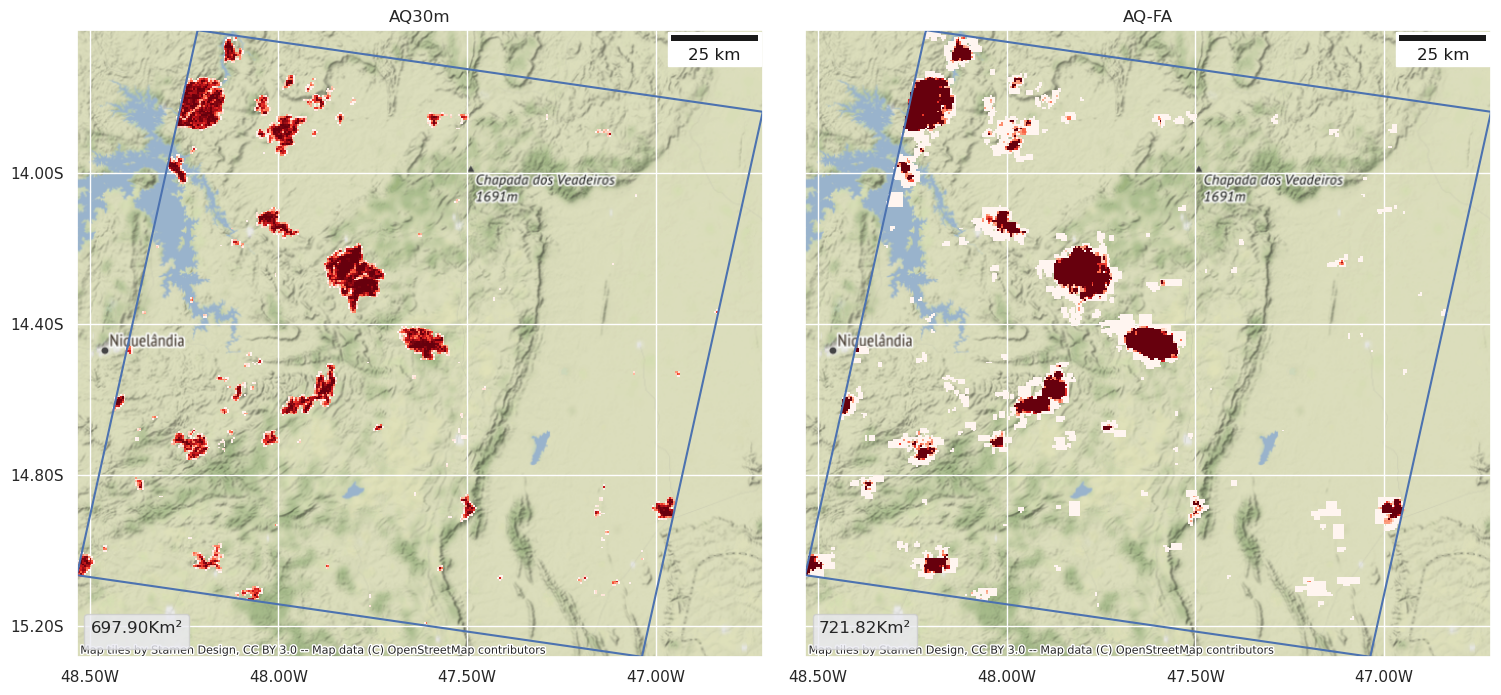

In [45]:
validate_plot(file='aq30m/LS8_AQM_221_070_20170910_0110.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 3.2906973360265264 max_range: 9.438837495794449
{'TP': 294.42016875892267, 'FP': 611.2382060684231, 'FN': 224.75186054699435, 'TN': 88707.58976462566, 'ACC': 0.9906944715308064, 'CE': 0.6749103448471386, 'OE': 0.43290440905968286, 'B': 1.7444282890935472, 'DC': 0.413270474724353, 'TPR': 0.5670955909403171, 'TNR': 0.9931566701001835, 'PPV': 0.3250896551528613, 'NPV': 0.9974727769848424, 'CSI': 0.26045426655343773}


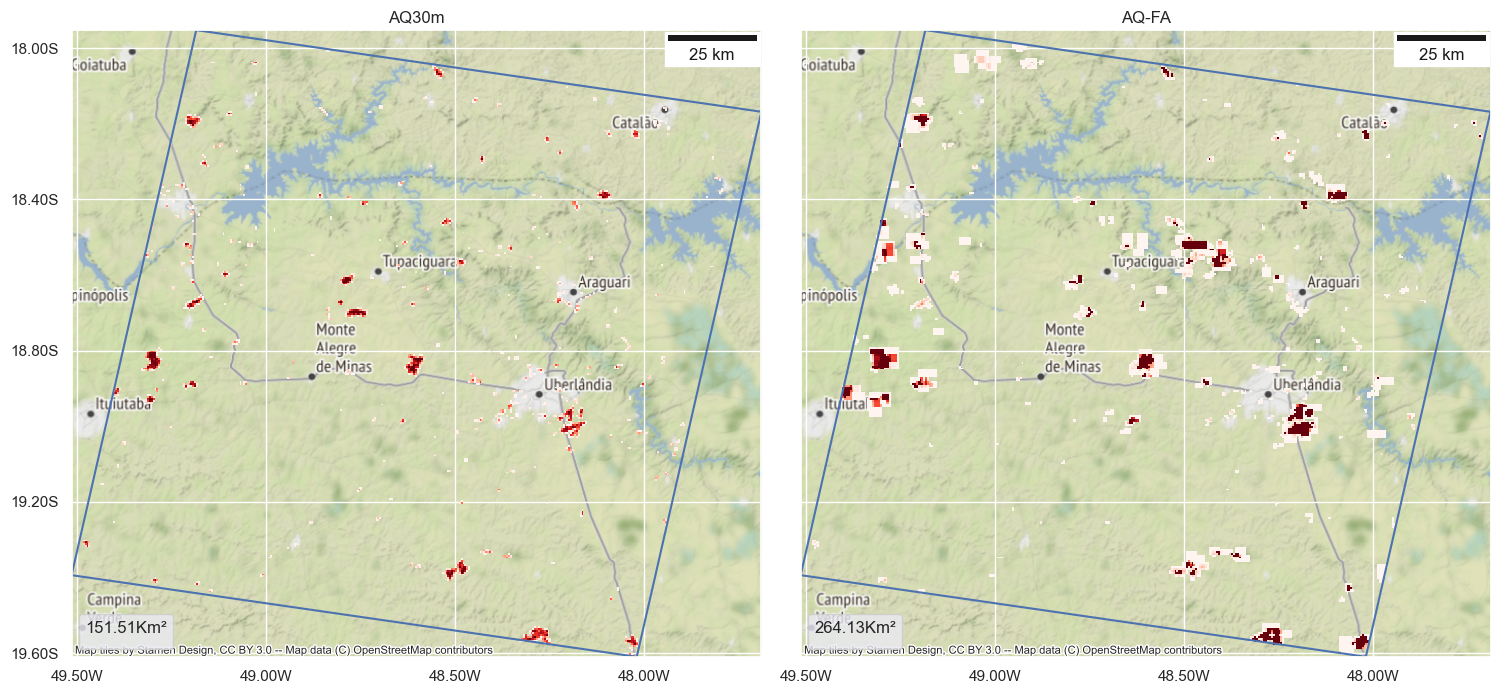

In [157]:
validate_plot(file='aq30m/LS8_AQM_221_073_20200918_0113.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 5.442141051994357 max_range: 15
{'TP': 395.3999522296828, 'FP': 322.5853884009249, 'FN': 417.35998801848217, 'TN': 88763.65467135092, 'ACC': 0.9917691478612731, 'CE': 0.4492924439342977, 'OE': 0.5135095461164672, 'B': 0.883391645030365, 'DC': 0.5166110353810021, 'TPR': 0.48649045388353285, 'TNR': 0.9963789538296312, 'PPV': 0.5507075560657024, 'NPV': 0.9953200802927327, 'CSI': 0.34826404112672593}


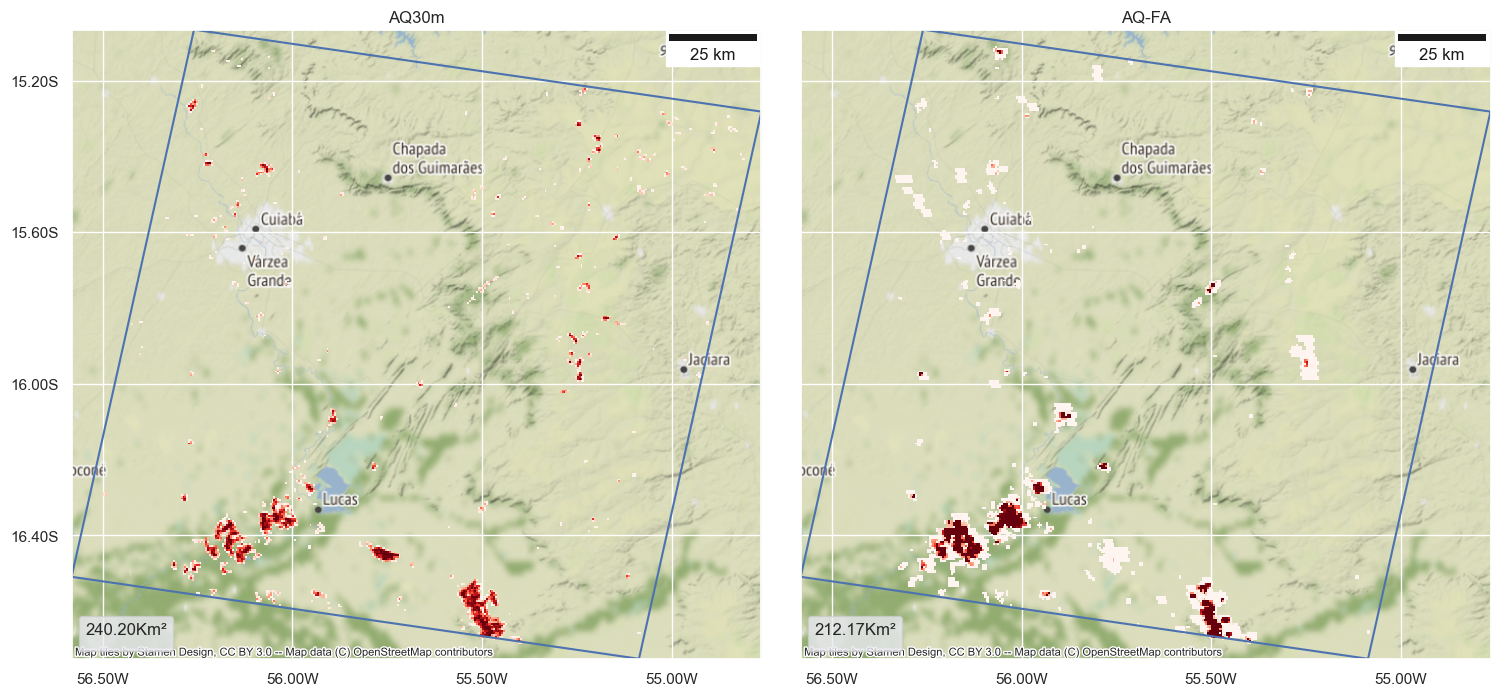

In [158]:
validate_plot(file='aq30m/LS8_AQM_226_071_20191005_0111.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 8.75 max_range: 15
{'TP': 2134.739165244317, 'FP': 690.5694712660811, 'FN': 1807.2644041034964, 'TN': 85315.42695938611, 'ACC': 0.9722302455266424, 'CE': 0.2444226667281982, 'OE': 0.4584634113871439, 'B': 0.7167189442646377, 'DC': 0.630897201224543, 'TPR': 0.541536588612856, 'TNR': 0.9919706822788468, 'PPV': 0.7555773332718018, 'NPV': 0.979256099922771, 'CSI': 0.460810686961436}


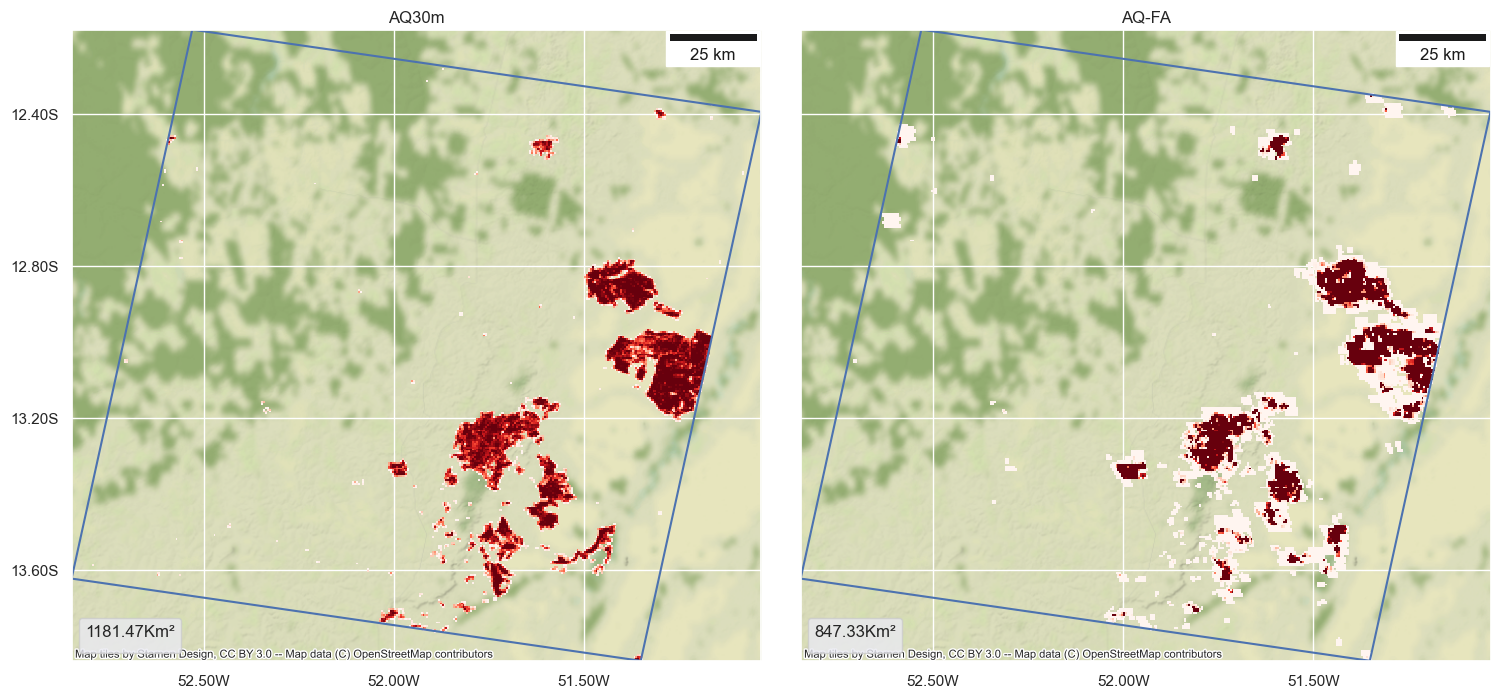

In [164]:
validate_plot(file='aq30m/LS8_AQM_224_069_20210910_0109.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 3.5 max_range: 8.75
{'TP': 343.75085334815464, 'FP': 351.25174910644637, 'FN': 506.4125482952719, 'TN': 88785.58484925012, 'ACC': 0.9904690199984252, 'CE': 0.5053963076769786, 'OE': 0.5956649596022838, 'B': 0.817492967953115, 'DC': 0.4449371167065188, 'TPR': 0.4043350403977161, 'TNR': 0.9960594097512214, 'PPV': 0.4946036923230214, 'NPV': 0.9943285785618545, 'CSI': 0.28612162343183356}


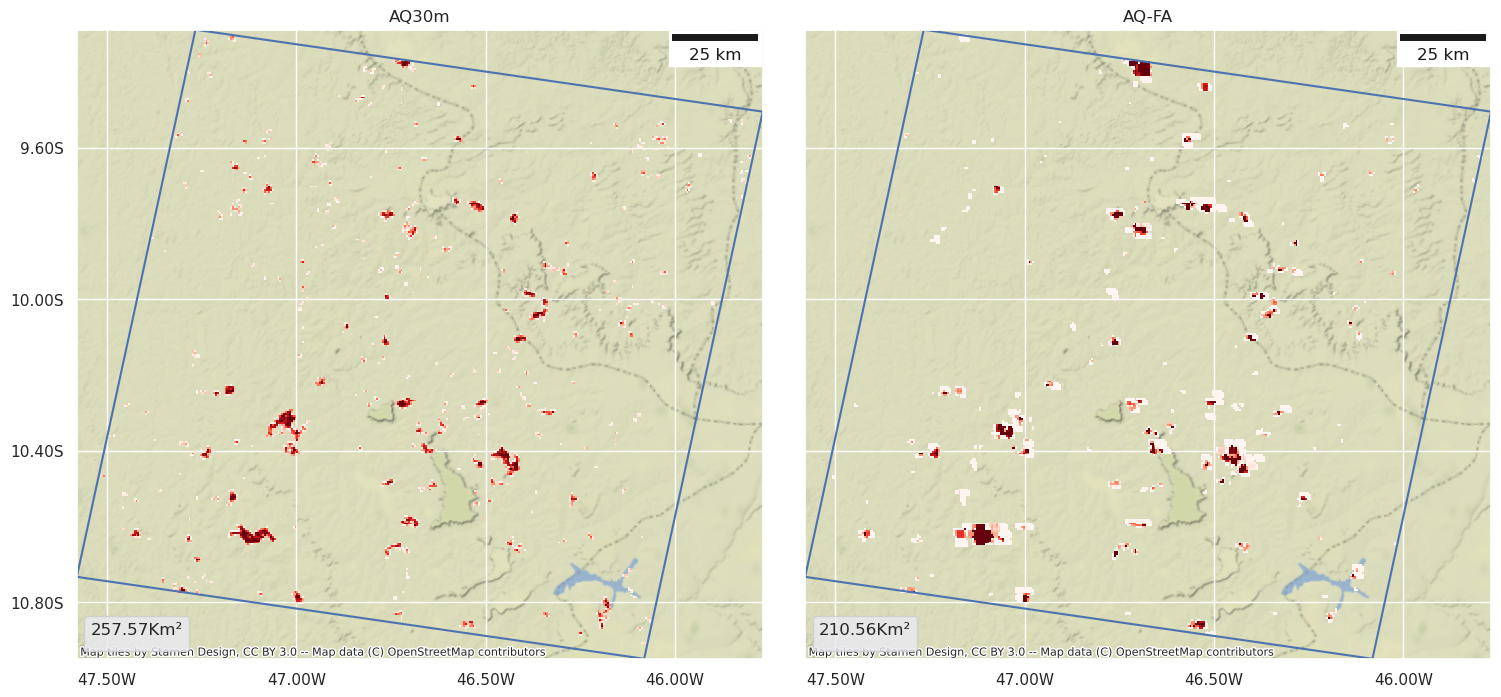

In [46]:
validate_plot(file='aq30m/LS8_AQM_221_067_20210719_0107.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


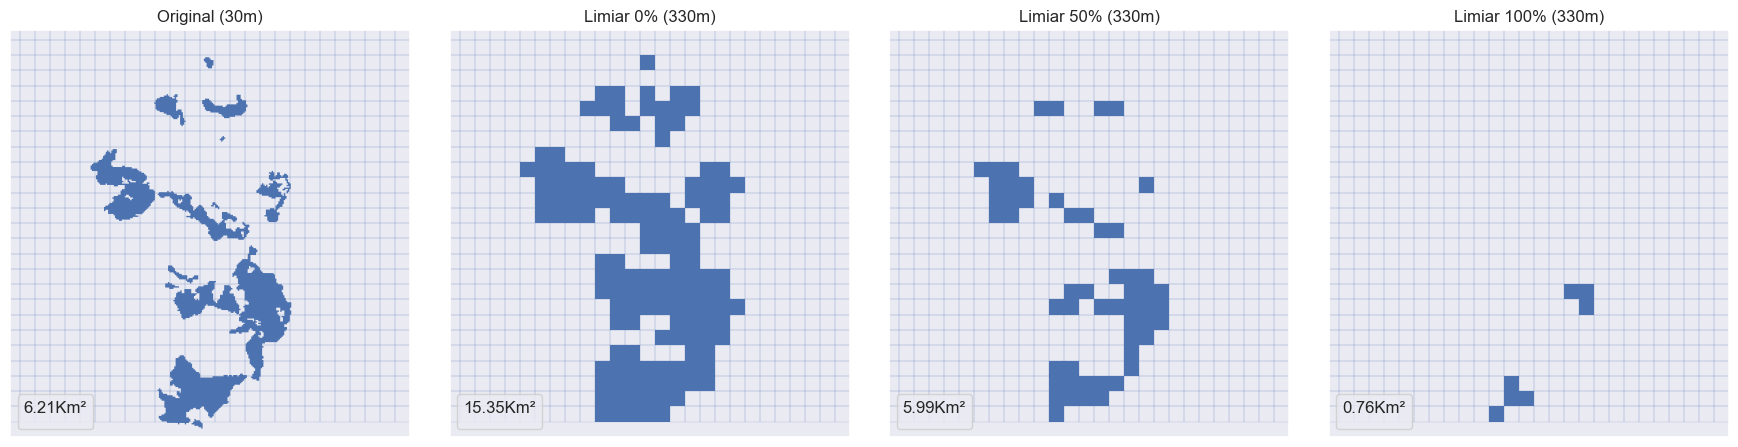

In [152]:
# cmap1 = copy.copy(plt.cm.rainbow)
quadrat_width = 0.003
linewidth = 0.1
geometry = box(-47.27, -10.77, -47.19, -10.69)
xmin, ymin, xmax, ymax = geometry.bounds
geod = Geod(ellps="WGS84")

fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('aq30m/LS8_AQM_221_067_20210820_0107.zip', engine="pyogrio")
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

threshold = [0.0, 0.5, 0.9999]

for i, t in enumerate(threshold):
    ax = axs[i+1]
    test = normalize_gdf(aqm30, geometry, quadrat_width)
    test.loc[test['value'] > t, 'value'] = 1
    test.loc[test['value'] <= t, 'value'] = 0
    plot_burned_gdf(ax, test, simple = True)
    test.boundary.plot(ax=ax, linewidth=linewidth)
    new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
    ax.set_title(f"Limiar {round(t * 100)}% ({round(new_resolution)}m)")

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'diferenca_resoluções.pdf'), bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


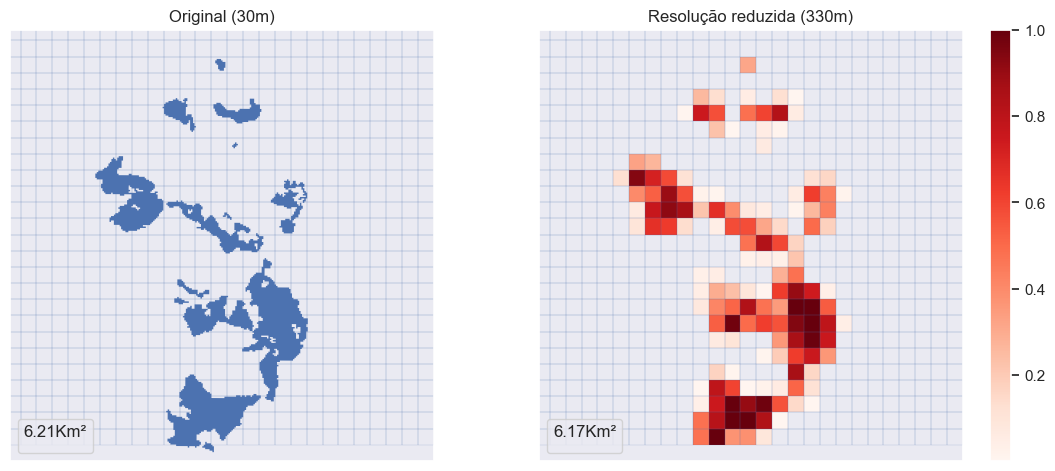

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('aq30m/LS8_AQM_221_067_20210820_0107.zip', engine="pyogrio")
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

ax2 = axs[1]
test = normalize_gdf(aqm30, geometry, quadrat_width)
plot_burned_gdf(ax2, test)
test.boundary.plot(ax=ax2, linewidth=linewidth)
new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
ax2.set_title(f'Resolução reduzida ({round(new_resolution)}m)')

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'resolução_continua.pdf'), bbox_inches="tight")